In [ ]:
# upgrade scipy to be able to use qmc
# after that automatically restarts the cell
import os
! pip install scipy --upgrade
os.kill(os.getpid(), 9)

In [1]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [2]:
tf.keras.backend.set_floatx("float64")

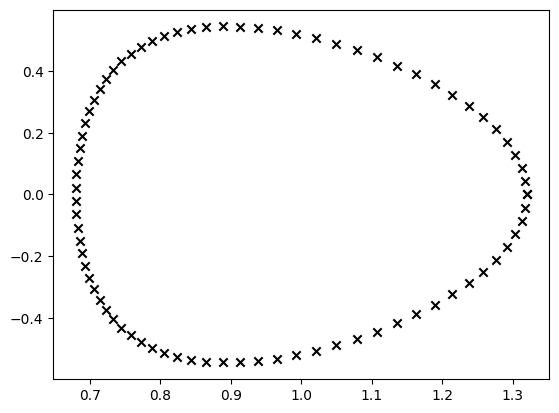

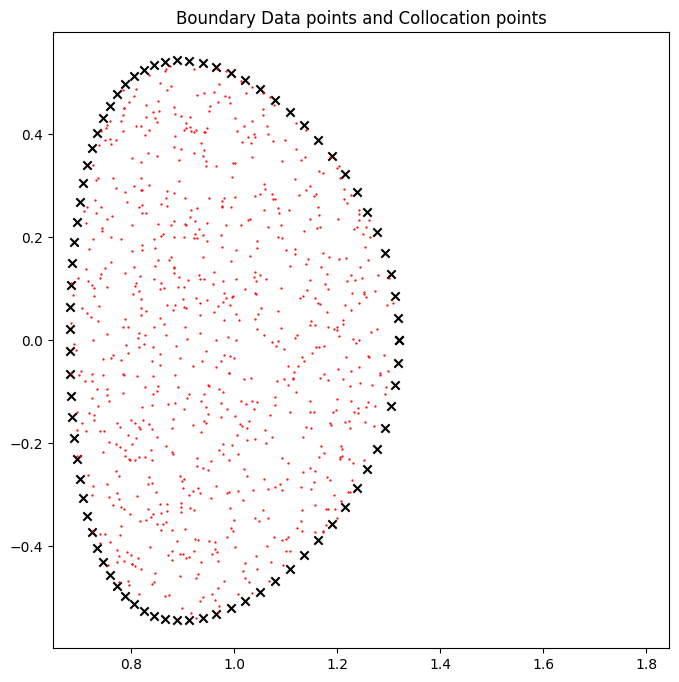

In [3]:
# .......................................................................
## We solve Grad-Shafranov for Soloviev equilibria parametrized following
## see Paper ...........................................................
#.......... this is a tokamak-like D-shape ITER equilibrium .....................

## parameters for the boundary .... 
epsi=0.32
delta=0.33
alfa=np.arcsin(delta)
kapa=1.7

n_bc = 1
n_data_per_bc = 80

# Choose linear or random .....
theta = np.linspace(0, 2*np.pi,n_data_per_bc)
#theta=2.*np.pi*np.random.rand(n_data_per_bc )

x= 1 +epsi*np.cos(theta + alfa*np.sin(theta))
y = kapa*epsi*np.sin(theta)

data = np.zeros([n_bc, n_data_per_bc, 3])
data[0, :, 0] = x 
data[0, :, 1] = y
data[0, :, 2] = 0.000 

data = data.reshape(n_data_per_bc * n_bc, 3)
#
x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2]])

plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.show()


# collocation points ............................
Nc = 800
expo=0.5       # parameter allowing to accumulate the data near the cente or the boundary
# must vary between 0 and 1 ................................................
colloc = np.zeros([Nc, 2]) 

engine = qmc.LatinHypercube(d=2)
points = engine.random(n=Nc)

points[:, 0] = points[:, 0]*2*np.pi

colloc[:, 1] = kapa*epsi*points[:, 1]**expo*np.sin(points[:, 0])
colloc[:, 0] = 1 + epsi*points[:, 1]**expo* np.cos(points[:, 0] + alfa*np.sin(points[:, 0]) )

#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

#
plt.figure("", figsize=(8, 8))
plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=1.5, marker=".", c="r", label="CP")
plt.axis("square")
plt.show()

#

x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d])

In [4]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=5, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [5]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 5, 20, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

Model: "DNN-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 21    

In [6]:
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

@tf.function
def um(x, y):
    u = model(tf.concat([x, y], axis=1))
    
    zab = tf.math.abs(y)
    rab = tf.math.abs(x)-1
    
    facteur = tf.math.acos((rab)/epsi) - tf.math.asin(zab/epsi/kapa)    
    um =  u*(zab - epsi*kapa/np.arcsin(delta)*facteur)
    return um

@tf.function

def um2(x, y):
    u = model(tf.concat([x, y], axis=1))
    
    zab = tf.math.abs(y)
    rab = tf.math.abs(x)-1
    a1= tf.math.acos( ( rab)/epsi)
    a2= (zab/epsi/kapa)*np.arcsin(delta)
    
    um2 =  u*(zab**2 - (epsi*kapa*tf.math.sin((a1-a2)))**2)
    return um2

In [7]:
# Define the residual ... Soloviev formulation for source term
@tf.function
def f(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]

    # Choose the coefficient ... is -0.155 for ITER-like equilibrium
    AA= -0.155

    F = x*u_xx + x*u_yy - u_x 
    F = F + x*((1-AA)*x*x + AA)

    retour = tf.reduce_mean(tf.square(F)) 
    return retour



In [8]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

    0, 0.500934236
  200, 0.048781259
  400, 0.044036746
  600, 0.037905875
  800, 0.022039845
 1000, 0.009287991
 1200, 0.006646036
 1400, 0.004731135
 1600, 0.003448286
 1800, 0.002549668
 2000, 0.002006465
 2200, 0.001621124
 2400, 0.001329505
 2600, 0.001121682
 2800, 0.000971263
 3000, 0.000831419
 3200, 0.000734877
 3400, 0.000681963
 3600, 0.000591984
 3800, 0.000541941
 4000, 0.000496794
 4200, 0.000462609
 4400, 0.000430399
 4600, 0.000405913
 4800, 0.000381518
 5000, 0.000363337
 5200, 0.000344451
 5400, 0.000329468
 5600, 0.000314193
 5800, 0.000302393
 6000, 0.000288820
 6200, 0.000276620
 6400, 0.000267157
 6600, 0.000256696
 6800, 0.000248522
 7000, 0.000239626
 7200, 0.000305839
 7400, 0.000224548
 7600, 0.000216934
 7800, 0.000211202
 8000, 0.000204641
 8200, 0.000221083
 8400, 0.000193442
 8600, 0.000187663
 8800, 0.000183185
 9000, 0.000178055
 9200, 0.000178356
 9400, 0.000169201
 9600, 0.000164600
 9800, 0.000160909
10000, 0.000156684
10200, 0.000152463
10400, 0.000

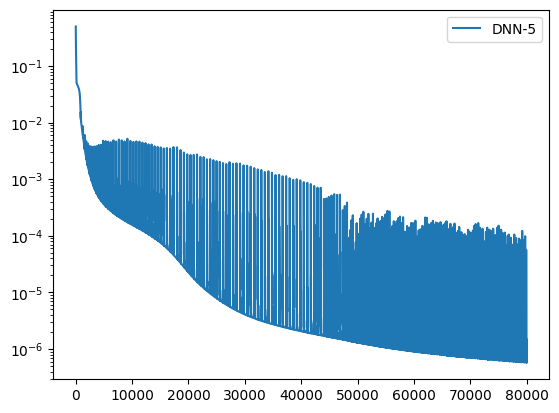

In [9]:
loss = 0
epochs = 80000
opt = tf.keras.optimizers.legacy.Adam(learning_rate=3e-4)
epoch = 0
loss_values = np.array([])
L_values = np.array([])
l_values = np.array([])

#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)
        L = f(x_c, y_c)
        l = mse(t_d, T_)
        loss = L + l
        
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    loss_values = np.append(loss_values, loss)
    L_values = np.append(L_values, L)
    l_values = np.append(l_values, l)
    
    
    if epoch % 200 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.9f}")

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()

In [10]:
n = 200
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])



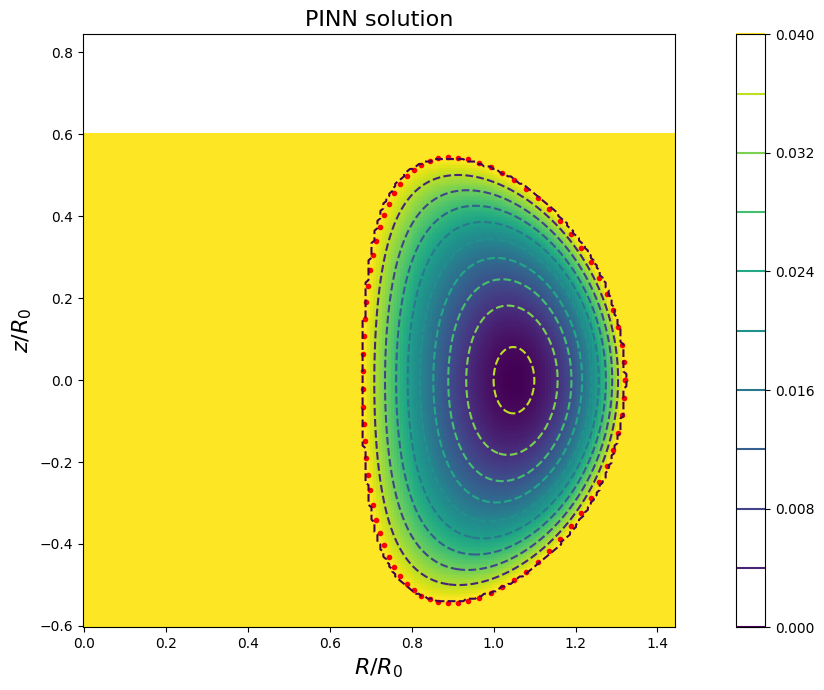

In [11]:
### plotting the results ....
#plt.figure("", figsize=(16, 8))
plt.figure("", figsize=(14, 7))
#
X = np.linspace(0., +1.44, n)
Y = np.linspace(-0.6, +0.6, n)
X0, Y0 = np.meshgrid(X, Y)


X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

# Predicted solution .....
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)
#

S2=S
S2[S <  0] =  0.00000000000000000
plt.pcolormesh(X0, Y0, S2, cmap="viridis_r")
plt.contour(X0, Y0, S2,10,linestyles='dashed',linewidths=1.5)
plt.colorbar(pad=-0.25)
plt.scatter(data[:, 0], data[:, 1], marker=".", c="r", label="BDP")
plt.xlabel("$R/R_0$",fontsize=16)
plt.ylabel("$z/R_0$",fontsize=16)
plt.xlim(0.66, 1.34)
plt.ylim(-0.52, 0.52)
plt.title("PINN solution",fontsize=16)
plt.tight_layout()
plt.axis("square")

plt.show()
#





No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


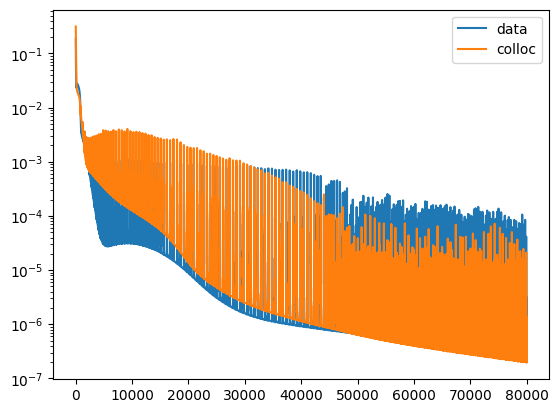

In [12]:
plt.legend()
plt.semilogy(l_values, label='data')
plt.legend()

plt.semilogy(L_values, label='colloc')
plt.legend()